In [49]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 15.1.1 Generate 100 random samples

In [5]:
def gen_random(n=100):
    means = [20, 5]
    covs = [[2, 0.8], [0.8, 0.5]]
    return pd.DataFrame(stats.multivariate_normal.rvs(means, covs, size=n), columns=['ut', 'uc'])

In [6]:
rand_data = gen_random()

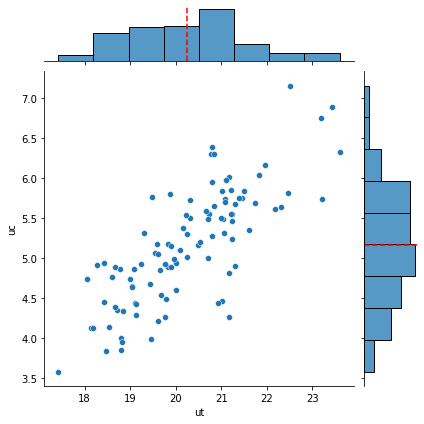

In [7]:
g = sns.jointplot(data=rand_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rand_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rand_data.uc.mean(), color='r', linestyle='--')

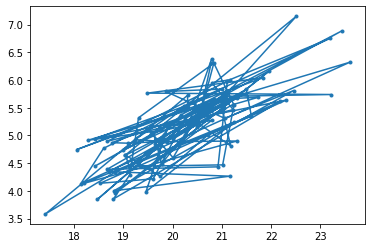

In [8]:
plt.plot(rand_data.ut, rand_data.uc, '.-')

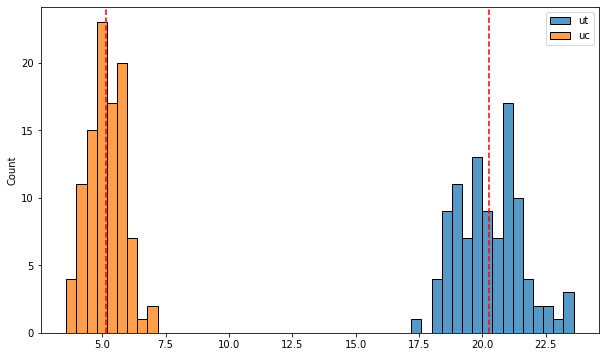

In [9]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rand_data, bins=50, stat='count')
ax.axvline(rand_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rand_data.uc.mean(), color='r', linestyle='--')

### 15.1.2 Code up a Random Walk Metropolis sampler

In [10]:
def propose_step(current):
    return stats.multivariate_normal.rvs(current)

In [11]:
def calc_ratio(current, proposed):
    p_current = stats.multivariate_normal.pdf(current, mean=[5,20], cov=[[2, 0.8], [0.8, 0.5]])
    p_proposed = stats.multivariate_normal.pdf(proposed, mean=[5,20], cov=[[2, 0.8], [0.8, 0.5]])
    return p_proposed/p_current

In [12]:
def get_next_value(current):
    proposed = propose_step(current)
    ratio = calc_ratio(current, proposed)
    u = stats.uniform.rvs()
    if ratio > u:
        return proposed, 1
    return current, 0

In [13]:
def RWMetropolis(start, n):
    results = [start]
    num_accepted = 0
    for _ in range(n):
        next_step, accepted = get_next_value(results[-1])
        results.append(next_step)
        num_accepted += accepted
    stats = {'steps': n, 'acc_steps': num_accepted, 'perc_accepted': num_accepted/n}
    return pd.DataFrame(results, columns=['ut', 'uc']), stats

In [42]:
rmw_data, rmw_stats = RWMetropolis((5, 10), 100)

{'steps': 100, 'acc_steps': 40, 'perc_accepted': 0.4}

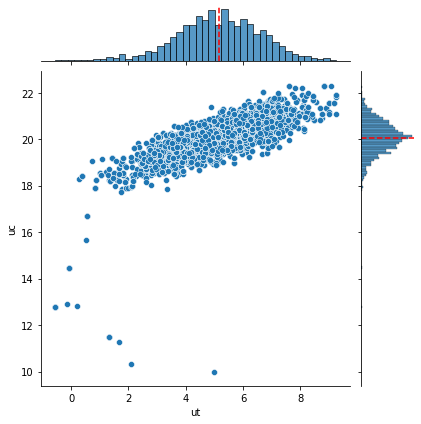

In [22]:
g = sns.jointplot(data=rmw_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rmw_data.uc.mean(), color='r', linestyle='--')

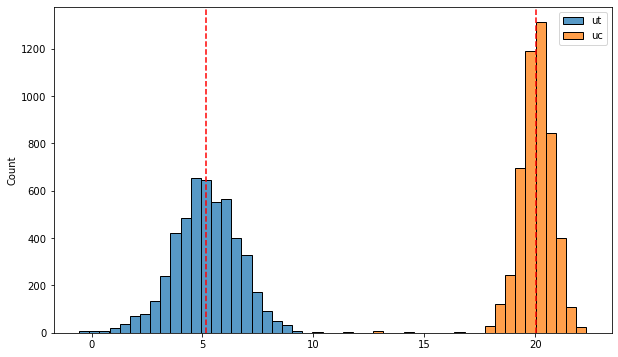

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rmw_data, bins=50, stat='count')
ax.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rmw_data.uc.mean(), color='r', linestyle='--')

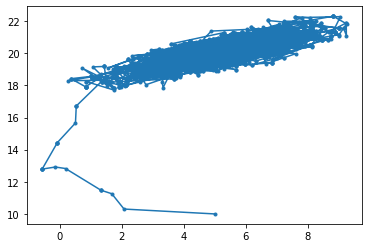

In [24]:
plt.plot(rmw_data.ut, rmw_data.uc, '.-')

### 15.1.3 Code up a Random Walk Metropolis sampler

In [25]:
rmw_stats

{'steps': 5000, 'acc_steps': 1891, 'perc_accepted': 0.3782}

### 15.1.4 Calculate Gelman's R

In [82]:
def calc_W(chains):
    '''Calculate within chain variance'''
    # chains is list of lists at the moment
    return np.mean([np.var(c, ddof=1) for c in chains])

In [83]:
def calc_B(chains):
    '''Calculate between chain variance'''
    # chains is list of lists at the moment
    glob_mean = np.mean(chains)
    chain_means = [np.mean(c) for c in chains]
    n_chains = len(chains)
    t = len(chains[0])
    return np.sum((chain_means-glob_mean)**2)*t/(n_chains-1)

In [85]:
def calc_R(chains):
    B = calc_B(chains)
    W = calc_W(chains)
    T = len(chains[0])
    return np.sqrt((W + (B-W)/T)/W)